In [ ]:
pip install qiskit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 14.5 MB/s eta 0:00:00


In [ ]:
pip install qiskit-aer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 16.2 MB/s eta 0:00:00


In [ ]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136816 sha256=57d312957a9fe2676f6ac244da04f72ab3f857a7225e2de08ecad2591e2de945
  Stored in directory: /root/.cache/pip/wheels/d3/31/8b/e09b0386afd80cfc556c00408c9aeea5c35c4d484a9c762fd5
Successfully built pylatexenc


In [ ]:
from qiskit_aer import Aer
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.circuit.library import QFT
import numpy as np
import matplotlib.pyplot as plt

# Simple numpy element wise multiplication followed by state prepartion

Classical Preprocessing of first two quantum states for new windowed state preparation

# Sliding window functionality

In [ ]:
def pad_to_power_of_two(coeffs):
    length = len(coeffs)
    next_power_of_two = 1 << (length - 1).bit_length()
    return coeffs + [0] * (next_power_of_two - length)

def ensure_same_length(coeffs_psi1, coeffs_psi2):
    len1 = len(coeffs_psi1)
    len2 = len(coeffs_psi2)

    if len1 > len2:
        coeffs_psi2 = coeffs_psi2 + [0] * (len1 - len2)
    elif len2 > len1:
        raise ValueError("Window is larger than the input signal.")

    return coeffs_psi1, coeffs_psi2

In [ ]:
def normalize(coeffs):
    norm = np.linalg.norm(coeffs)
    return [c / norm for c in coeffs]

def translate_coefficients(coeffs, m):
    return [0]*m + coeffs

# Define the coefficients for the two initial states (works with complex numbers) (following values are same as in the QWFT paper)
coeffs_psi1 = [1/3, 1/4, np.sqrt(3)/3, 5/12, np.sqrt(2)/6, 5/12, np.sqrt(13)/12] # Input signal
coeffs_psi2 = [1/2, np.sqrt(2)/2, 1/2] # window specifications

# Define the translation parameter
m = 1 # set zero to position the window at the very start

# Translate coeffs_psi2 by m positions
coeffs_psi2 = translate_coefficients(coeffs_psi2, m)

# Ensure coefficients are padded to a power of 2
coeffs_psi1 = pad_to_power_of_two(coeffs_psi1)
coeffs_psi2 = pad_to_power_of_two(coeffs_psi2)

# Ensure the lengths are the same
coeffs_psi1, coeffs_psi2 = ensure_same_length(coeffs_psi1, coeffs_psi2)

# Normalize the coefficients
coeffs_psi1 = normalize(coeffs_psi1)
coeffs_psi2 = normalize(coeffs_psi2)

# Print the normalized coefficients for verification
print("Normalized coefficients of psi1:", coeffs_psi1)
print("Normalized coefficients of psi2:", coeffs_psi2)

Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.5, 0.7071067811865476, 0.5, 0.0, 0.0, 0.0, 0.0]


In [ ]:
def elementwise_multiply_and_normalize(coeffs_psi1, coeffs_psi2):
    # Element-wise multiplication of coefficients
    multiplied_coeffs = [a * b for a, b in zip(coeffs_psi1, coeffs_psi2)]

    # Normalize the resulting coefficients
    norm = np.linalg.norm(multiplied_coeffs)
    normalized_coeffs = [c / norm for c in multiplied_coeffs]

    return normalized_coeffs

# Compute the normalized coefficients of the resulting state
normalized_result_coeffs = elementwise_multiply_and_normalize(coeffs_psi1, coeffs_psi2)

# Print the resulting normalized coefficients for verification
print("Normalized coefficients of the resulting state:", normalized_result_coeffs)

Normalized coefficients of the resulting state: [0.0, 0.26311740579210874, 0.8593378488473195, 0.4385290096535146, 0.0, 0.0, 0.0, 0.0]


Statevector of the third register: Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.33567254+0.j, 0.83918136+0.j,
             0.42790021+0.j, 0.        +0.j],
            dims=(2, 2, 2))



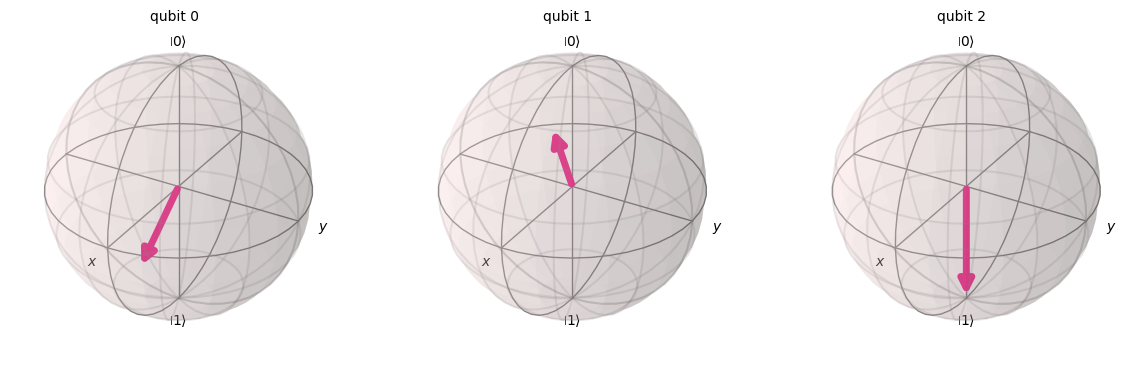

In [ ]:
# Create a quantum circuit for the resulting state
num_qubits = int(np.log2(len(coeffs_psi1)))
qc3 = QuantumCircuit(num_qubits)
qc3.initialize(normalized_result_coeffs, range(num_qubits))

# Simulate the quantum circuit using the statevector simulator
simulator = Aer.get_backend('statevector_simulator')
compiled_circuit_qc3 = transpile(qc3, simulator)
result_qc3 = simulator.run(compiled_circuit_qc3).result()
statevector_qc3 = result_qc3.get_statevector()

# Print the statevector of the third register
print("Statevector of the third register:", statevector_qc3)
print()

# Plot the statevector of the third register on the Bloch sphere
plot_bloch_multivector(statevector_qc3)
# plt.show()

<ipython-input-18-cfb061c28dca>:4: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(range(len(coeffs)), np.abs(coeffs)**2, basefmt=" ", use_line_collection=True)


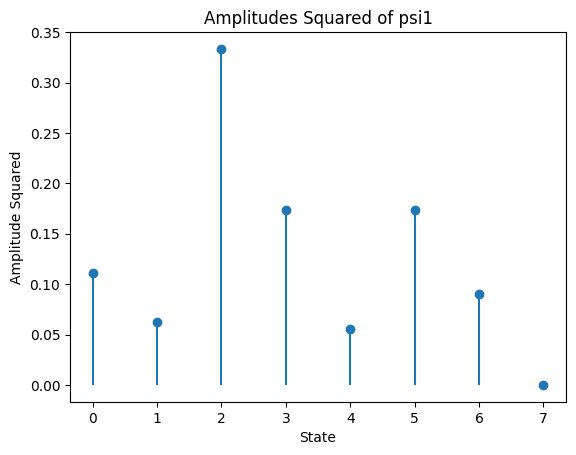

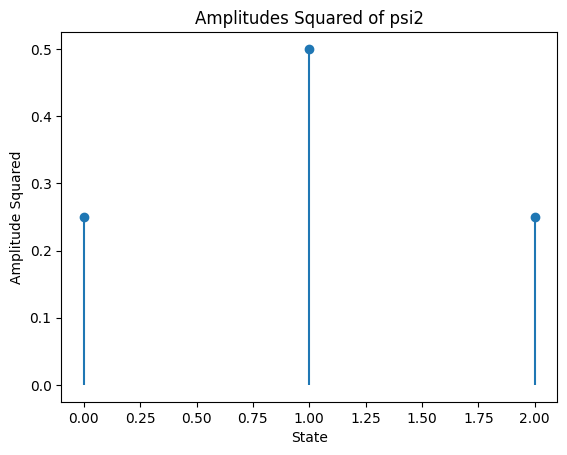

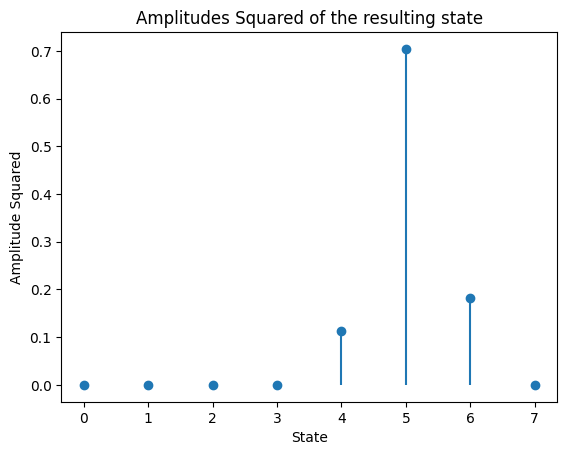

In [ ]:
#Plot the Squares of the Amplitudes:
def plot_amplitudes(coeffs, title):
    fig, ax = plt.subplots()
    ax.stem(range(len(coeffs)), np.abs(coeffs)**2, basefmt=" ", use_line_collection=True)
    ax.set_xlabel('State')
    ax.set_ylabel('Amplitude Squared')
    ax.set_title(title)
    plt.show()

# Plot the amplitudes of psi1
plot_amplitudes(coeffs_psi1, "Amplitudes Squared of psi1")
print()

# Plot the amplitudes of psi2
plot_amplitudes(coeffs_psi2, "Amplitudes Squared of psi2")
print()

# Plot the amplitudes of the resulting state
# plot_amplitudes(coeffs_third_register, "Amplitudes Squared of the resulting state")
plot_amplitudes(normalized_result_coeffs, "Amplitudes Squared of the resulting state")

# QWFT : Simply applying QFT to the windowed state

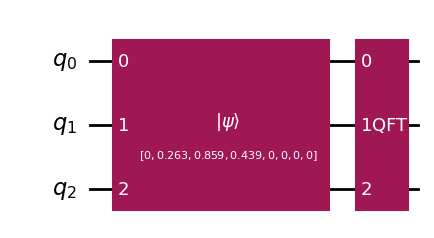

In [ ]:
# Create a quantum circuit for the resulting state
num_qubits = int(np.log2(len(normalized_result_coeffs)))
qc3 = QuantumCircuit(num_qubits)
qc3.initialize(normalized_result_coeffs, range(num_qubits))

# Append QFT to the circuit
qc3.append(QFT(num_qubits), range(num_qubits))

# Draw the circuit
qc3.draw(output='mpl')
# plt.show()

Statevector of the third register after QFT: Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.33567254+0.j, 0.83918136+0.j,
             0.42790021+0.j, 0.        +0.j],
            dims=(2, 2, 2))



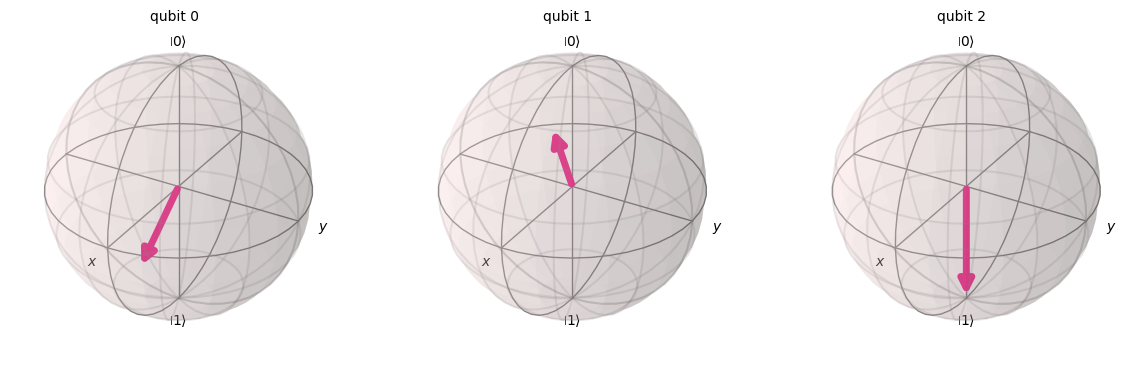

In [ ]:
# Simulate the quantum circuit using the statevector simulator
simulator = Aer.get_backend('statevector_simulator')
compiled_circuit_qc3 = transpile(qc3, simulator)
result_qc3 = simulator.run(compiled_circuit_qc3).result()
statevector_qc3 = result_qc3.get_statevector()

# Print the statevector of the third register
print("Statevector of the third register after QFT:", statevector_qc3)
print()

# Plot the statevector of the third register on the Bloch sphere
plot_bloch_multivector(statevector_qc3)
# plt.show()

# Sliding window loop demo

<ipython-input-16-97ec9ef03a25>:36: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(range(len(coeffs)), np.abs(coeffs)**2, basefmt=" ", use_line_collection=True)


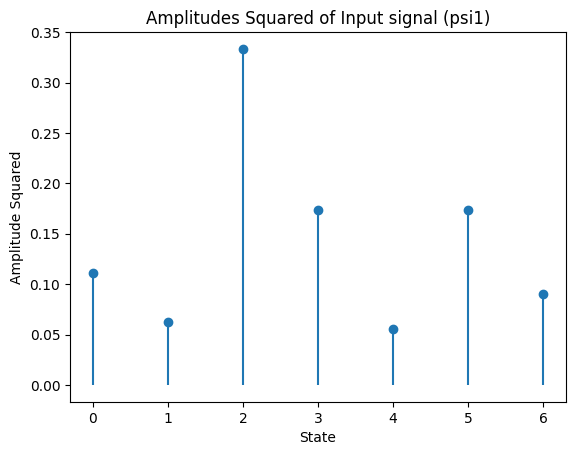

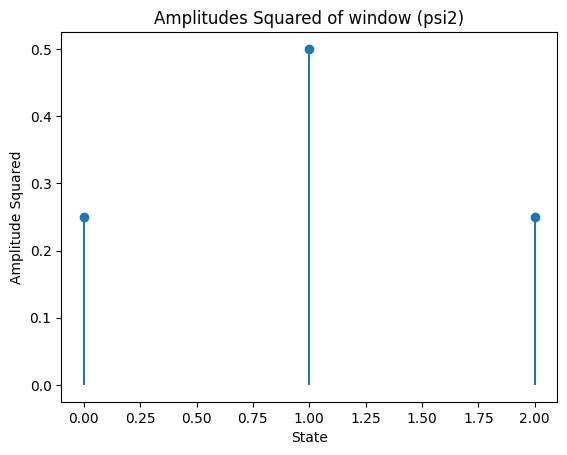


m value is satisfying the conditions. m =  1
Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.5, 0.7071067811865476, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]

Statevector of the third register (Window starting at index 0): Statevector([0.4417261 +0.j, 0.46852129+0.j, 0.76509206+0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))



<ipython-input-16-97ec9ef03a25>:36: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  ax.stem(range(len(coeffs)), np.abs(coeffs)**2, basefmt=" ", use_line_collection=True)


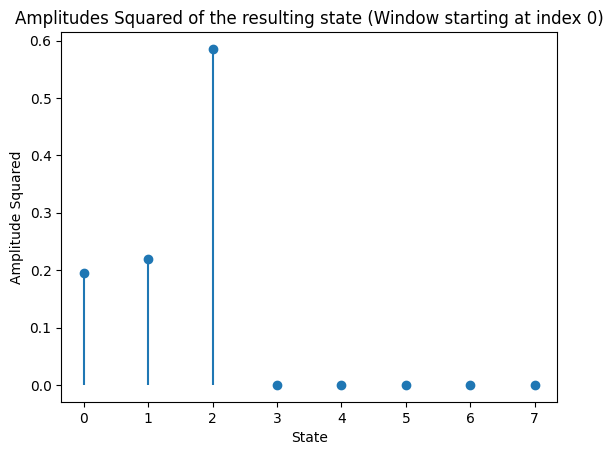


Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.5, 0.7071067811865476, 0.5, 0.0, 0.0, 0.0, 0.0]

Statevector of the third register (Window starting at index 1): Statevector([0.        +0.j, 0.26311741+0.j, 0.85933785+0.j,
             0.43852901+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))



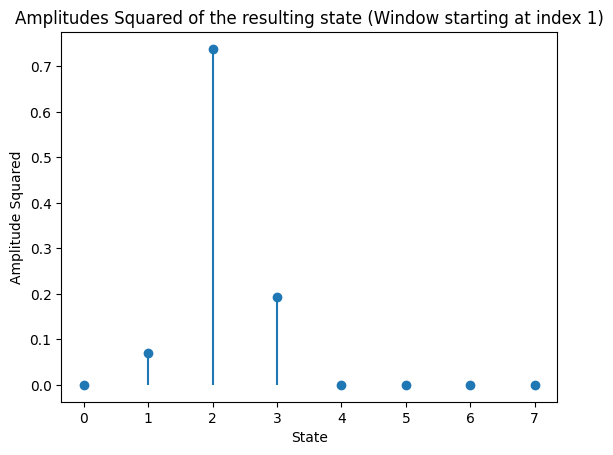


Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.0, 0.5, 0.7071067811865476, 0.5, 0.0, 0.0, 0.0]

Statevector of the third register (Window starting at index 2): Statevector([0.        +0.j, 0.        +0.j, 0.67292658+0.j,
             0.68680282+0.j, 0.27472113+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))



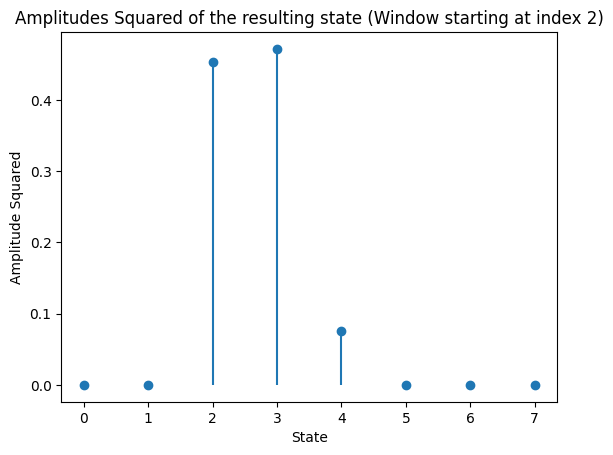


Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.0, 0.0, 0.5, 0.7071067811865476, 0.5, 0.0, 0.0]

Statevector of the third register (Window starting at index 3): Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.61545745+0.j, 0.49236596+0.j, 0.61545745+0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))



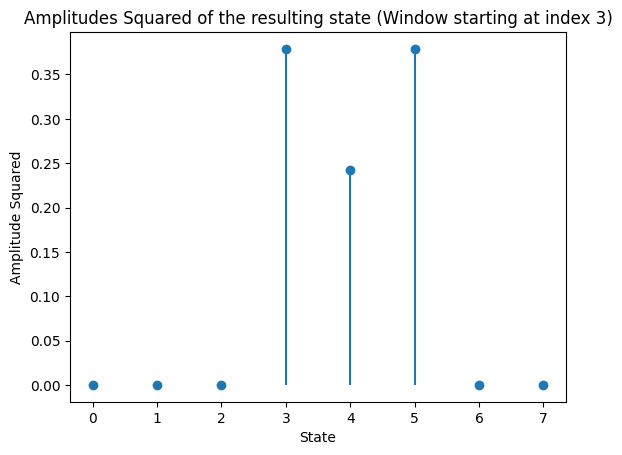


Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.0, 0.0, 0.0, 0.5, 0.7071067811865476, 0.5, 0.0]

Statevector of the third register (Window starting at index 4): Statevector([0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.33567254+0.j, 0.83918136+0.j,
             0.42790021+0.j, 0.        +0.j],
            dims=(2, 2, 2))



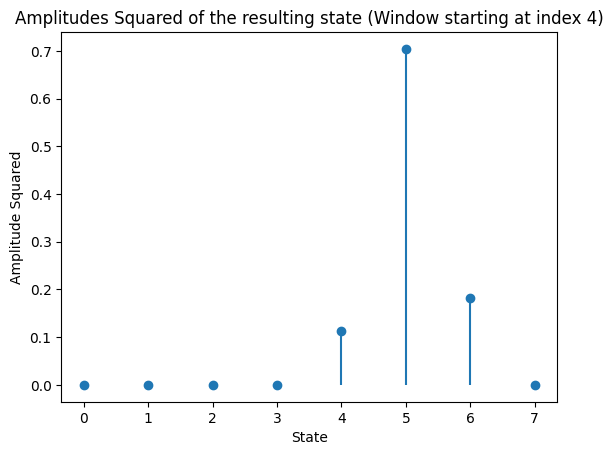

In [ ]:
def pad_to_power_of_two(coeffs):
    length = len(coeffs)
    next_power_of_two = 1 << (length - 1).bit_length()
    return coeffs + [0] * (next_power_of_two - length)

def ensure_same_length(coeffs_psi1, coeffs_psi2):
    len1 = len(coeffs_psi1)
    len2 = len(coeffs_psi2)

    if len1 > len2:
        coeffs_psi2 = coeffs_psi2 + [0] * (len1 - len2)
    elif len2 > len1:
        raise ValueError("Window is larger than the input signal.")

    return coeffs_psi1, coeffs_psi2

def normalize(coeffs):
    norm = np.linalg.norm(coeffs)
    return [c / norm for c in coeffs]

def translate_coefficients(coeffs, m):
    return [0]*m + coeffs

def elementwise_multiply_and_normalize(coeffs_psi1, coeffs_psi2):
    # Element-wise multiplication of coefficients
    multiplied_coeffs = [a * b for a, b in zip(coeffs_psi1, coeffs_psi2)]

    # Normalize the resulting coefficients
    norm = np.linalg.norm(multiplied_coeffs)
    normalized_coeffs = [c / norm for c in multiplied_coeffs]

    return normalized_coeffs

def plot_amplitudes(coeffs, title):
    fig, ax = plt.subplots()
    ax.stem(range(len(coeffs)), np.abs(coeffs)**2, basefmt=" ", use_line_collection=True)
    ax.set_xlabel('State')
    ax.set_ylabel('Amplitude Squared')
    ax.set_title(title)
    plt.show()

# Define the coefficients for the two initial states (works with complex numbers)
coeffs_psi1 = [1/3, 1/4, np.sqrt(3)/3, 5/12, np.sqrt(2)/6, 5/12, np.sqrt(13)/12]  # Input signal
coeffs_psi2 = [1/2, np.sqrt(2)/2, 1/2]  # Window specifications

# Define the translation parameter
m = 1 # Move the window by m sample, must be non zero positive integer

# Plot the amplitudes of psi1
plot_amplitudes(coeffs_psi1, "Amplitudes Squared of Input signal (psi1)")
print()

# Plot the amplitudes of psi2
plot_amplitudes(coeffs_psi2, "Amplitudes Squared of window (psi2)")
print()

# Checking if m value is satisfying the conditions
if len(coeffs_psi1) - len(coeffs_psi2) + 1 > m:
     print("m value is satisfying the conditions. m = ", m)
elif m > len(coeffs_psi1) - len(coeffs_psi2) + 1:
     raise ValueError("m value is very large")

# # Ensure coefficients are padded to a power of 2
# coeffs_psi1 = pad_to_power_of_two(coeffs_psi1)
# coeffs_psi2 = pad_to_power_of_two(coeffs_psi2)

# # Ensure the lengths are the same
# coeffs_psi1, coeffs_psi2 = ensure_same_length(coeffs_psi1, coeffs_psi2)

# # Normalize the coefficients
# coeffs_psi1 = normalize(coeffs_psi1)
# coeffs_psi2 = normalize(coeffs_psi2)

# # Print the normalized coefficients for verification
# print("Normalized coefficients of psi1:", coeffs_psi1)
# print("Normalized coefficients of psi2:", coeffs_psi2)

# Main loop to iterate over the length of coeffs_psi1 with sliding window
for i in range(0, len(coeffs_psi1) - len(coeffs_psi2) + 1, m):
    # Apply the window to the current position
    current_window_psi2 = translate_coefficients(coeffs_psi2, i)

    ### Ensure coefficients are padded to a power of 2
    coeffs_psi1 = pad_to_power_of_two(coeffs_psi1)
    current_window_psi2 = pad_to_power_of_two(current_window_psi2)

    # Ensure the lengths are the same for the current window
    # current_window_psi2, _ = ensure_same_length(current_window_psi2, coeffs_psi1)
    # current_window_psi2, coeffs_psi1 = ensure_same_length(current_window_psi2, coeffs_psi1)
    coeffs_psi1, current_window_psi2  = ensure_same_length(coeffs_psi1, current_window_psi2)

    # Normalize the current window and the window coefficients
    # coeffs_psi1_segment = normalize(coeffs_psi1[:len(current_window_psi2)]) # whats up with segment??
    coeffs_psi1_segment = normalize(coeffs_psi1)
    current_window_psi2 = normalize(current_window_psi2)


    # Print the normalized coefficients for verification
    print("Normalized coefficients of psi1:", coeffs_psi1_segment)
    print("Normalized coefficients of psi2:", current_window_psi2)
    print()

    # Compute the normalized coefficients of the resulting state
    normalized_result_coeffs = elementwise_multiply_and_normalize(coeffs_psi1_segment, current_window_psi2)

    # Create a quantum circuit for the resulting state
    num_qubits = int(np.log2(len(normalized_result_coeffs)))
    qc3 = QuantumCircuit(num_qubits)
    qc3.initialize(normalized_result_coeffs, range(num_qubits))

    # # Draw the circuit
    # qc3.draw(output='mpl')
    # plt.title(f'Circuit for Window starting at index {i}')
    # # plt.show()

    # Simulate the quantum circuit using the statevector simulator
    simulator = Aer.get_backend('statevector_simulator')
    compiled_circuit_qc3 = transpile(qc3, simulator)
    result_qc3 = simulator.run(compiled_circuit_qc3).result()
    statevector_qc3 = result_qc3.get_statevector()

    # Print the statevector of the third register
    print(f"Statevector of the third register (Window starting at index {i}):", statevector_qc3)
    print()

    # Plot the statevector of the third register on the Bloch sphere
    # plot_bloch_multivector(statevector_qc3)
    # plt.title(f'Bloch Sphere for Window starting at index {i}')
    # # plt.show()

    # Plot the amplitudes of the resulting state
    plot_amplitudes(statevector_qc3, f'Amplitudes Squared of the resulting state (Window starting at index {i})')
    print()

# QWFT : Simply applying QFT to the looped sliding windowed state

We pretty much have the STFT for each windowed input signal at this stage.

<ipython-input-17-171c8c4a87dd>:36: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax.stem(range(len(coeffs)), np.abs(coeffs)**2, basefmt=" ", use_line_collection=True)


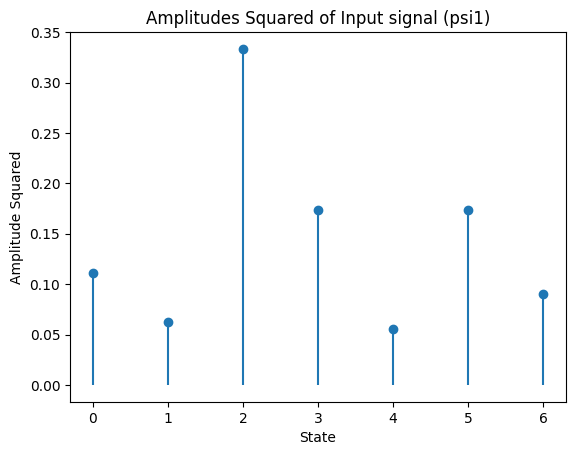

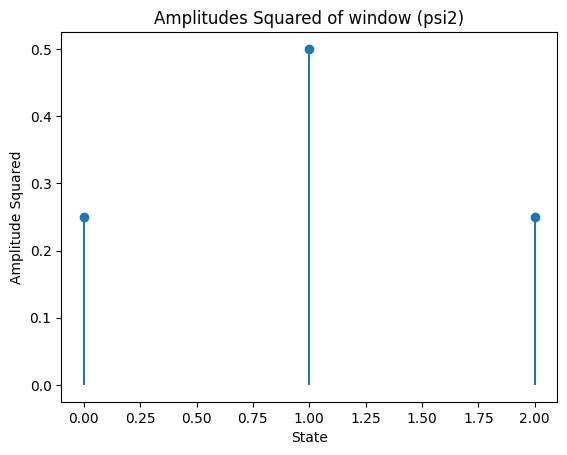


m value is satisfying the conditions. m =  1
Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.5, 0.7071067811865476, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]

Statevector of the third register after QFT: Statevector([ 0.59232194-5.34127472e-17j,  0.27330408+3.87631212e-01j,
             -0.11432713+1.65647289e-01j,  0.03904344-1.53370569e-01j,
              0.26102736-1.28408627e-17j,  0.03904344+1.53370569e-01j,
             -0.11432713-1.65647289e-01j,  0.27330408-3.87631212e-01j],
            dims=(2, 2, 2))



<ipython-input-17-171c8c4a87dd>:36: DeprecationWarning: The return type of saved statevectors has been changed from a `numpy.ndarray` to a `qiskit.quantum_info.Statevector` as of qiskit-aer 0.10. Accessing numpy array attributes is deprecated and will result in an error in a future release. To continue using saved result objects as arrays you can explicitly cast them using  `np.asarray(object)`.
  ax.stem(range(len(coeffs)), np.abs(coeffs)**2, basefmt=" ", use_line_collection=True)


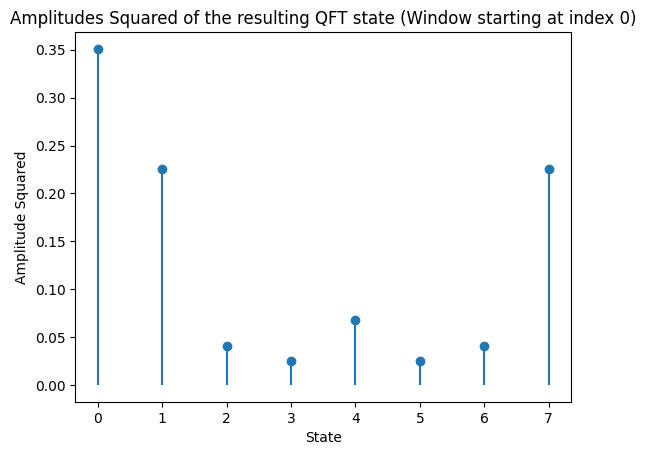


Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.5, 0.7071067811865476, 0.5, 0.0, 0.0, 0.0, 0.0]

Statevector of the third register after QFT: Statevector([ 0.55189128-8.65745315e-17j, -0.0438529 +4.79233414e-01j,
             -0.30382181-6.20173673e-02j,  0.0438529 -1.28410206e-01j,
              0.05575234+1.21596500e-17j,  0.0438529 +1.28410206e-01j,
             -0.30382181+6.20173673e-02j, -0.0438529 -4.79233414e-01j],
            dims=(2, 2, 2))



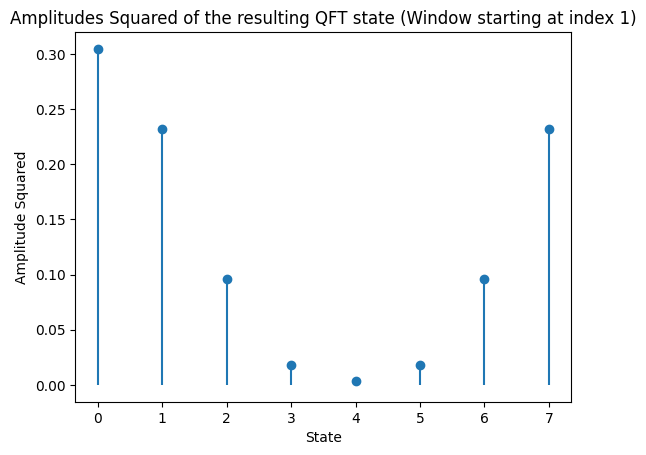


Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.0, 0.5, 0.7071067811865476, 0.5, 0.0, 0.0, 0.0]

Statevector of the third register after QFT: Statevector([ 0.57786553-1.00505170e-16j, -0.26882929+4.09616181e-01j,
             -0.14078689-2.42821466e-01j,  0.07457212-6.62147708e-02j,
              0.0922226 +1.84430423e-17j,  0.07457212+6.62147708e-02j,
             -0.14078689+2.42821466e-01j, -0.26882929-4.09616181e-01j],
            dims=(2, 2, 2))



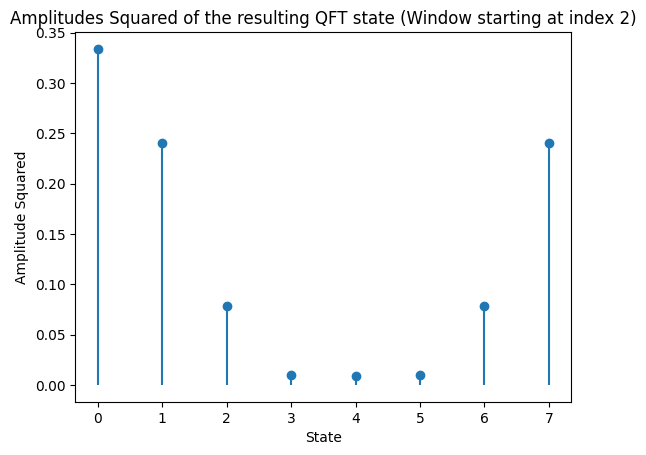


Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.0, 0.0, 0.5, 0.7071067811865476, 0.5, 0.0, 0.0]

Statevector of the third register after QFT: Statevector([ 0.6092718 -1.27910187e-16j, -0.48180638+9.82565760e-17j,
              0.17407766-6.05706759e-17j,  0.13365107-1.13715109e-16j,
             -0.26111648+8.52734577e-17j,  0.13365107-5.56198472e-17j,
              0.17407766+1.79339471e-17j, -0.48180638+1.56351838e-16j],
            dims=(2, 2, 2))



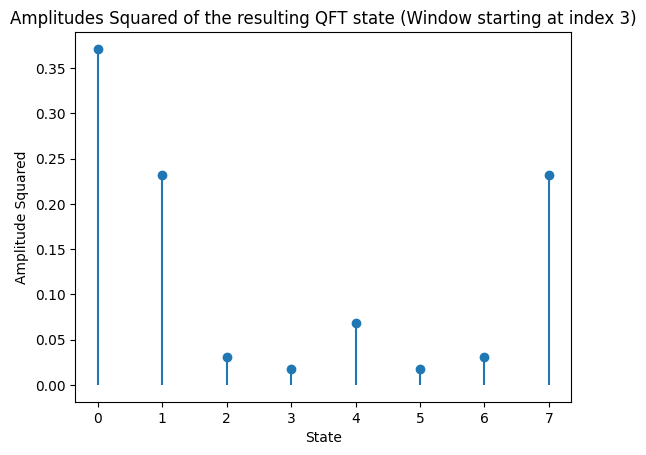


Normalized coefficients of psi1: [0.3333333333333333, 0.25, 0.5773502691896257, 0.4166666666666667, 0.23570226039551587, 0.4166666666666667, 0.3004626062886658, 0.0]
Normalized coefficients of psi2: [0.0, 0.0, 0.0, 0.0, 0.5, 0.7071067811865476, 0.5, 0.0]

Statevector of the third register after QFT: Statevector([ 0.56665915-1.24257580e-16j, -0.32847351-3.61080910e-01j,
             -0.03260741+2.96695415e-01j,  0.09111717-5.85097687e-02j,
             -0.02673168+2.10812563e-17j,  0.09111717+5.85097687e-02j,
             -0.03260741-2.96695415e-01j, -0.32847351+3.61080910e-01j],
            dims=(2, 2, 2))



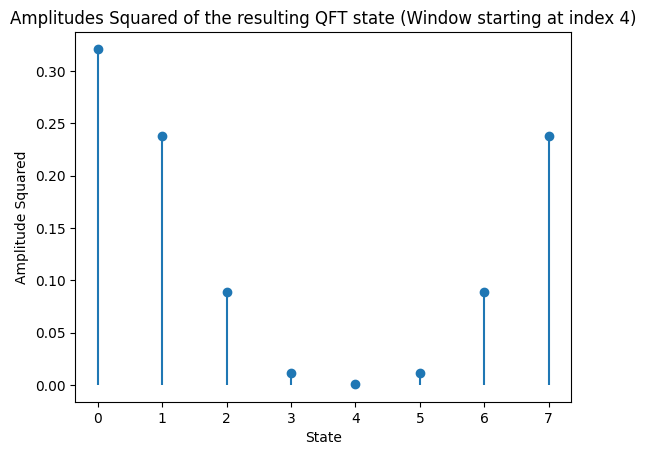

In [ ]:
def pad_to_power_of_two(coeffs):
    length = len(coeffs)
    next_power_of_two = 1 << (length - 1).bit_length()
    return coeffs + [0] * (next_power_of_two - length)

def ensure_same_length(coeffs_psi1, coeffs_psi2):
    len1 = len(coeffs_psi1)
    len2 = len(coeffs_psi2)

    if len1 > len2:
        coeffs_psi2 = coeffs_psi2 + [0] * (len1 - len2)
    elif len2 > len1:
        raise ValueError("Window is larger than the input signal.")

    return coeffs_psi1, coeffs_psi2

def normalize(coeffs):
    norm = np.linalg.norm(coeffs)
    return [c / norm for c in coeffs]

def translate_coefficients(coeffs, m):
    return [0]*m + coeffs

def elementwise_multiply_and_normalize(coeffs_psi1, coeffs_psi2):
    # Element-wise multiplication of coefficients
    multiplied_coeffs = [a * b for a, b in zip(coeffs_psi1, coeffs_psi2)]

    # Normalize the resulting coefficients
    norm = np.linalg.norm(multiplied_coeffs)
    normalized_coeffs = [c / norm for c in multiplied_coeffs]

    return normalized_coeffs

def plot_amplitudes(coeffs, title):
    fig, ax = plt.subplots()
    ax.stem(range(len(coeffs)), np.abs(coeffs)**2, basefmt=" ", use_line_collection=True)
    ax.set_xlabel('State')
    ax.set_ylabel('Amplitude Squared')
    ax.set_title(title)
    plt.show()

# Define the coefficients for the two initial states (works with complex numbers)
coeffs_psi1 = [1/3, 1/4, np.sqrt(3)/3, 5/12, np.sqrt(2)/6, 5/12, np.sqrt(13)/12]  # Input signal
coeffs_psi2 = [1/2, np.sqrt(2)/2, 1/2]  # Window specifications

# Define the translation parameter
m = 1  # Move the window by m sample, must be non zero positive integer

# Plot the amplitudes of psi1
plot_amplitudes(coeffs_psi1, "Amplitudes Squared of Input signal (psi1)") #TODO: different coor for each plot
print()

# Plot the amplitudes of psi2
plot_amplitudes(coeffs_psi2, "Amplitudes Squared of window (psi2)")
print()

# Checking if m value is satisfying the conditions
if len(coeffs_psi1) - len(coeffs_psi2) + 1 > m:
     print("m value is satisfying the conditions. m = ", m)
elif m > len(coeffs_psi1) - len(coeffs_psi2) + 1:
     raise ValueError("m value is very large")

# # Ensure coefficients are padded to a power of 2
# coeffs_psi1 = pad_to_power_of_two(coeffs_psi1)
# coeffs_psi2 = pad_to_power_of_two(coeffs_psi2)

# # Ensure the lengths are the same
# coeffs_psi1, coeffs_psi2 = ensure_same_length(coeffs_psi1, coeffs_psi2)

# # Normalize the coefficients
# coeffs_psi1 = normalize(coeffs_psi1)
# coeffs_psi2 = normalize(coeffs_psi2)

# # Print the normalized coefficients for verification
# print("Normalized coefficients of psi1:", coeffs_psi1)
# print("Normalized coefficients of psi2:", coeffs_psi2)

# Main loop to iterate over the length of coeffs_psi1 with sliding window
for i in range(0, len(coeffs_psi1) - len(coeffs_psi2) + 1, m):
    # Apply the window to the current position
    current_window_psi2 = translate_coefficients(coeffs_psi2, i)

    ### Ensure coefficients are padded to a power of 2
    coeffs_psi1 = pad_to_power_of_two(coeffs_psi1)
    current_window_psi2 = pad_to_power_of_two(current_window_psi2)

    # Ensure the lengths are the same for the current window
    # current_window_psi2, _ = ensure_same_length(current_window_psi2, coeffs_psi1)
    # current_window_psi2, coeffs_psi1 = ensure_same_length(current_window_psi2, coeffs_psi1)
    coeffs_psi1, current_window_psi2  = ensure_same_length(coeffs_psi1, current_window_psi2)

    # Normalize the current window and the window coefficients
    # coeffs_psi1_segment = normalize(coeffs_psi1[:len(current_window_psi2)]) # whats up with segment??
    coeffs_psi1_segment = normalize(coeffs_psi1)
    current_window_psi2 = normalize(current_window_psi2)


    # Print the normalized coefficients for verification
    print("Normalized coefficients of psi1:", coeffs_psi1_segment)
    print("Normalized coefficients of psi2:", current_window_psi2)
    print()

    # Compute the normalized coefficients of the resulting state
    normalized_result_coeffs = elementwise_multiply_and_normalize(coeffs_psi1_segment, current_window_psi2)

    # Create a quantum circuit for the resulting state
    # qc3 refers to the supposed third quantum register. although the first two registers are classical here. this is for future followup work puropses we stick with qc3
    num_qubits = int(np.log2(len(normalized_result_coeffs)))
    qc3 = QuantumCircuit(num_qubits)
    qc3.initialize(normalized_result_coeffs, range(num_qubits))

    # Append QFT to the circuit
    qc3.append(QFT(num_qubits), range(num_qubits))

    # # Draw the circuit
    # qc3.draw(output='mpl')
    # plt.title(f'Circuit for Window starting at index {i}')
    # # plt.show()

    # Simulate the quantum circuit using the statevector simulator
    simulator = Aer.get_backend('statevector_simulator')
    compiled_circuit_qc3 = transpile(qc3, simulator)
    result_qc3 = simulator.run(compiled_circuit_qc3).result()
    statevector_qc3 = result_qc3.get_statevector()

    # Print the statevector of the third register
    # print(f"Statevector of the third register (Window starting at index {i}):", statevector_qc3)
    # Print the statevector of the third register
    print("Statevector of the third register after QFT:", statevector_qc3)
    print()

    # Plot the statevector of the third register on the Bloch sphere
    # plot_bloch_multivector(statevector_qc3)
    # plt.title(f'Bloch Sphere for Window starting at index {i}')
    # # plt.show()

    # Plot the amplitudes of the resulting state
    plot_amplitudes(statevector_qc3, f'Amplitudes Squared of the resulting QFT state (Window starting at index {i})')
    print()



---



---



TODO: Demonstrate with FRQA

# Ignore the code after this. These are a bunch of testing code snippets

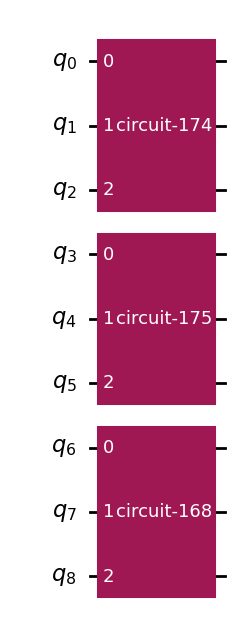

In [ ]:
# Create quantum circuits for the initial states
qc1 = QuantumCircuit(num_qubits)
qc2 = QuantumCircuit(num_qubits)

# Initialize the quantum registers with the given coefficients
qc1.initialize(coeffs_psi1, range(num_qubits))
qc2.initialize(coeffs_psi2, range(num_qubits))

# Create the final combined quantum circuit
qc_combined = QuantumCircuit(3 * num_qubits)

# Add the initial states
qc_combined.append(qc1.to_instruction(), range(num_qubits))
qc_combined.append(qc2.to_instruction(), range(num_qubits, 2 * num_qubits))

# Add the resulting state
qc_combined.append(qc3.to_instruction(), range(2 * num_qubits, 3 * num_qubits))

# Draw the combined circuit
qc_combined.draw(output='mpl')
# plt.show()

Coefficients of the third register: [ 0.        +0.00000000e+00j  0.09198188-1.44290886e-17j
  0.13008202-2.04058128e-17j  0.09198188-1.44290886e-17j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j -0.00730882+7.98722357e-02j
 -0.01033623+1.12956399e-01j -0.00730882+7.98722357e-02j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j -0.05063697-1.03362279e-02j
 -0.07161149-1.46176337e-02j -0.05063697-1.03362279e-02j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.00730882-2.14017010e-02j
  0.01033623-3.02665759e-02j  0.00730882-2.14017010e-02j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.        +0.00000000e+00j
  0.        +0.00000000e+00j  0.00929206+2.02660833e

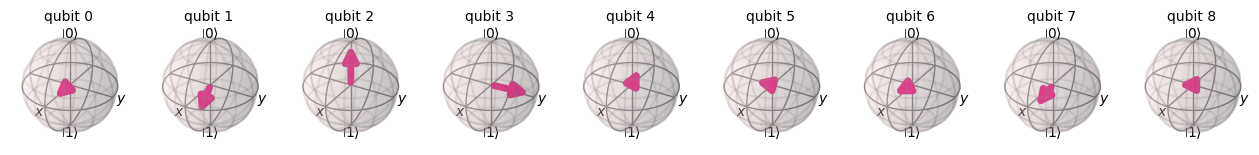

In [ ]:
# Simulate the quantum circuit using the statevector simulator
compiled_circuit = transpile(qc_combined, simulator)
result = simulator.run(compiled_circuit).result()
statevector = result.get_statevector()

# Extract the statevector corresponding to the third register
# This assumes num_qubits = n and we want the last n qubits
statevector_array = np.array(statevector.data)
num_states = 2 ** (3 * num_qubits)
statevector_reshaped = statevector_array.reshape([2] * (3 * num_qubits))

# Trace out the first two registers by summing over the appropriate indices
for i in range(2 * num_qubits):
    statevector_reshaped = np.tensordot(statevector_reshaped, np.eye(2), axes=(0, 0))

# Flatten the resulting statevector to get the coefficients
coeffs_third_register = statevector_reshaped.flatten()

# Print the coefficients of the third register
print("Coefficients of the third register:", coeffs_third_register)

# Plot the statevector of the third register on the Bloch sphere
plot_bloch_multivector(Statevector(coeffs_third_register))
# plt.show()

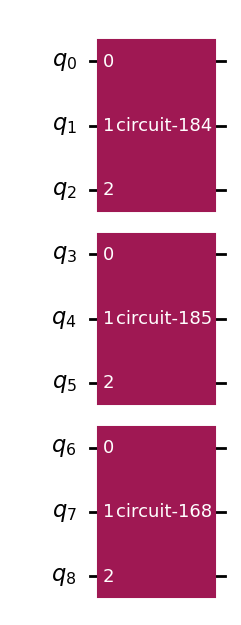

In [ ]:
# Create quantum circuits for the initial states
qc1 = QuantumCircuit(num_qubits)
qc2 = QuantumCircuit(num_qubits)

# Initialize the quantum registers with the given coefficients
qc1.initialize(coeffs_psi1, range(num_qubits))
qc2.initialize(coeffs_psi2, range(num_qubits))

# Create the final combined quantum circuit
qc_combined = QuantumCircuit(3 * num_qubits)

# Add the initial states
qc_combined.append(qc1, range(num_qubits))
qc_combined.append(qc2, range(num_qubits, 2 * num_qubits))

# Add the resulting state
qc_combined.append(qc3, range(2 * num_qubits, 3 * num_qubits))

# Draw the combined circuit
qc_combined.draw(output='mpl')
# plt.show()

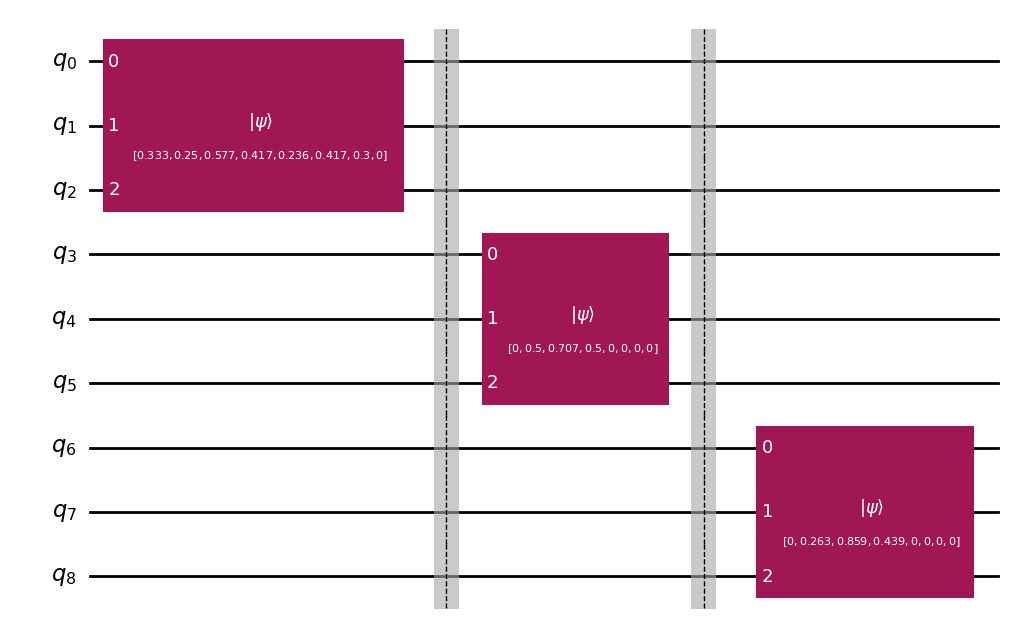

In [ ]:
# Create quantum circuits for the initial states
num_qubits = int(np.log2(len(coeffs_psi1)))
qc1 = QuantumCircuit(num_qubits)
qc2 = QuantumCircuit(num_qubits)
qc3 = QuantumCircuit(num_qubits)

# Initialize the quantum registers with the given coefficients
qc1.initialize(coeffs_psi1, range(num_qubits))
qc2.initialize(coeffs_psi2, range(num_qubits))
qc3.initialize(normalized_result_coeffs, range(num_qubits))

# Create the final combined quantum circuit
qc_combined = QuantumCircuit(3 * num_qubits)

# Add the initial states
qc_combined.compose(qc1, qubits=range(num_qubits), inplace=True)
qc_combined.barrier()
qc_combined.compose(qc2, qubits=range(num_qubits, 2 * num_qubits), inplace=True)
qc_combined.barrier()
qc_combined.compose(qc3, qubits=range(2 * num_qubits, 3 * num_qubits), inplace=True)

# Draw the combined circuit
qc_combined.draw(output='mpl')
# plt.show()